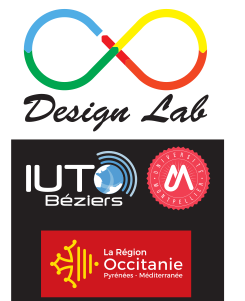

# Manipulation de paquet avec Scapy 

[Scapy](http://www.secdev.org/projects/scapy) est un puissant et interactif outil Python permettant la manipulation de paquets sur les couches réseaux. Il peut être utilisé afin de forger ou décoder des paquets (ethernet, ip , tcp,udp...) pour un grand nombre de protocoles. Ces paquets sont envoyés sur le réseaux et Scapy permet de capturer les réponses.

Ce notebok Jupyter s'inspire de 
- [https://github.com/secdev/scapy/blob/master/doc/notebooks/Scapy%20in%2015%20minutes.ipynb] 
- [https://guedou.github.io/talks/2017_BalCCon2k17/Scapy%20in%200x30%20minutes.slides.html#/30]

La documentation de Scapy est accessible sur: [http://scapy.readthedocs.io/](http://scapy.readthedocs.io/).

Vous pouvez utiliser le container python suivant pour expérimenter ce notebook:

```bash
git clone https://registry.iutbeziers.fr:11443/pouchou/Python3InDocker.git
cd Python3InDocker
docker-compose up -d
docker-compose exec pythondev bash 
```

Si vous êtes à l'extérieur de l'IUT et loin de son registry vous pouvez builder vous même le container pythondev avec la commande:

```bash
docker-compose build
```
Il est facile de repartir à zéro avec la commande:

```bash
docker-compose down 
docker-compose up -d
```
Tout ce qui est dans la directory /home/python/student est résilient à ce redémarrage.

## Un bref aperçu de Scapy

Nous allons tout d'abord importer le package Scapy dans notre Notebook. Si vous rechargez le noyau ipython ou si vous vous voulez rejouer juste une partie des cellules il vous faudra relancer cet import.

In [1]:
from scapy.all import *

Scapy facilite la manipulation de paquets et permet de forger des paquets complexes afin de réaliser des tests.
Comme entrée en matière voici l'envoi d'un paquet dont la couche TCP a un "Maximum Sergment Size" de taille nulle.



In [2]:
send(IP(dst="194.199.227.222")/TCP(dport=502, options=[("MSS", 0)]))


Sent 1 packets.


On se sert d'option de "Firewalking" dans ce one-liner complexe afin d'émuler un traceroute vers le DNS de Google:

In [12]:
ans = sr([IP(dst="8.8.8.8", ttl=(1, 8), options=IPOption_RR())/ICMP(seq=RandShort()), IP(dst="8.8.8.8", ttl=(1, 8), options=IPOption_Traceroute())/ICMP(seq=RandShort()), IP(dst="8.8.8.8", ttl=(1, 8))/ICMP(seq=RandShort())], verbose=False, timeout=3)[0]
ans.make_table(lambda x, y: (", ".join(z.summary() for z in x[IP].options) or '-', x[IP].ttl, y.sprintf("%IP.src% %ICMP.type%")))

  -                             IPOption_RR                   IPOption_Traceroute           
1 192.168.16.1 time-exceeded    192.168.16.1 time-exceeded    192.168.16.1 time-exceeded    
2 192.168.1.1 time-exceeded     192.168.1.1 time-exceeded     192.168.1.1 time-exceeded     
3 80.10.239.41 time-exceeded    80.10.239.41 time-exceeded    80.10.239.41 time-exceeded    
4 193.253.95.66 time-exceeded   193.253.95.66 time-exceeded   193.253.95.66 time-exceeded   
5 193.252.101.158 time-exceeded 193.252.101.158 time-exceeded 193.252.101.158 time-exceeded 
6 81.253.183.34 time-exceeded   81.253.183.34 time-exceeded   81.253.183.34 time-exceeded   
7 72.14.203.56 time-exceeded    -                             72.14.203.56 time-exceeded    
8 -                             216.239.35.215 time-exceeded  216.239.35.215 time-exceeded  


#### Démarrons ce tutoriel!

## Premiers pas

Dans Scapy chaque couche réseau est un classe Python.
L'opérateur `'/'` est utilisé afin d'assembler les couches réseaux.

Fabriquons un segment TCP au-dessus de la couche IP, lui même sur ethernet et assignons-le à la variable packet ( vous remarquerez que scapy permet d'afficher la représentation de la variable de façon claire)

In [1]:
packet = Ether()/IP()/TCP()
packet

NameError: name 'Ether' is not defined

Cette dernière instruction affiche un résumé du paquet. 

Scapy rempli automatiquement le type Ethernet et les champs de la couche IP.
Les champs d'une couche peuvent afficher avec la fonction `ls()`:

In [13]:
    >>> ls(IP, verbose=True)

version    : BitField (4 bits)                   = (4)
ihl        : BitField (4 bits)                   = (None)
tos        : XByteField                          = (0)
len        : ShortField                          = (None)
id         : ShortField                          = (1)
flags      : FlagsField (3 bits)                 = (<Flag 0 ()>)
               MF, DF, evil
frag       : BitField (13 bits)                  = (0)
ttl        : ByteField                           = (64)
proto      : ByteEnumField                       = (0)
chksum     : XShortField                         = (None)
src        : SourceIPField                       = (None)
dst        : DestIPField                         = (None)
options    : PacketListField                     = ([])


Créons un nouveau paquet destiné au serveur WWW de l'IUT de Béziers. C'est le champ dst qui va permmettre de spécifier une IP de destination.
Un paquet Scapy est un objet Python avec des méthodes utiles comme `summary()`.

In [6]:
p = Ether()/IP(dst="www.iutbeziers.fr")/TCP()
p.summary()

"Ether / IP / TCP 192.168.16.2:ftp_data > Net('www.iutbeziers.fr'):http S"

Scapy utilise le champ destination afin de réaliser des opérations magiques en utilisant des mécanismes internes comme le DNS, les tables de routage ou la résolution ARP pour remplir automatiquement le paquet des informations nécessaires à son envoi. Ces champs sont accessibles et peuvent être affichés:

In [8]:
print(p.dst)  # On affiche l'adresse  mac de destination
print(p[IP].src)  # ip source du paquet

# sprintf() est une méthode du package scapy afin d'afficher les flux 
print(p.sprintf("%Ether.src% > %Ether.dst%\n%IP.src% > %IP.dst%"))

02:42:a2:9f:fa:d7
192.168.16.2
02:42:c0:a8:10:02 > 02:42:a2:9f:fa:d7
192.168.16.2 > Net('www.iutbeziers.fr')


Scapy positionne automatiquement dans les champs paquets des valeurs par défaut. Par exemple `TCP()` positionne un flag SYN sur le port 80.

In [28]:
print(p.sprintf("%TCP.flags% %TCP.dport%"))

S http


De plus, Scapy peut faire varier des éléments comme par exemple ici le TTL d'une valeur de 1 à 5. Remarquez l'utilisation d'une "list comprehension" pour générer les paquets:

In [30]:
[p for p in IP(ttl=(1,5))/ICMP()]

[<IP  frag=0 ttl=1 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=2 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=3 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=4 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=5 proto=icmp |<ICMP  |>>]

## Envoyer et recevoir

**Vous savez maintenant  fabriquer un paquet mais il vous faut aussi l'envoyer et parfois recevoir la ou les réponses associées !**

-`send()`envoie un paquet de la couche 3 et ne réceptionne pas la réponse (utile pour le spoofing);

-`sendp()` envoie un paquet de la couche 2;

-`sr1()`  envoie un paquet de la couche 3 et retourne la première réponse;

-`srp1()` envoie un paquet de la couche 2 et retourne la première réponse;

-`sr()` envoie un paquet de la couche 3 et retourne toutes les réponses;

-`srp()` envoie un paquet de la couche 2 et retourne toutes les réponses;

Pour exemple construions et envoyons une requête DNS:

In [23]:
p,q=sr(IP(dst="10.255.255.211")/UDP()/DNS(qd=DNSQR(qname="www.iutbeziers.fr")))
p[0][1][DNS].an

Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets


<DNSRR  rrname='www.iutbeziers.fr.' type=A rclass=IN ttl=9948 rdata='194.199.227.80' |>

La méthode srp enregistre les réponses et les non réponses.

In [4]:
r, u = srp(Ether()/IP(dst="10.255.255.211", ttl=(5,10))/UDP()/DNS(rd=1, qd=DNSQR(qname="www.iutbeziers.fr")))
print(r,u)

Begin emission:
Finished sending 6 packets.

Received 7 packets, got 5 answers, remaining 0 packets
<Results: TCP:0 UDP:5 ICMP:0 Other:0> <Unanswered: TCP:0 UDP:1 ICMP:0 Other:0>



1. `r` est une liste de résultats ( tuples constitués du paquet envoyé et de sa réponse)
2. `u` (pour unanswer) est une liste de paquets sans réponses.

In [5]:
# Accès au premier tuple
print(r[0][0].summary())  # paquet envoyé
print(r[0][1].summary())  # réponse reçue

# Au niveau ICMP , Scapy reçoit un  messsage d'erreur "time-exceeded" 
r, u = srp(Ether()/IP(dst="10.255.255.204", ttl=(5,10))/ICMP())
r[0][1][ICMP]

Ether / IP / UDP / DNS Qry "b'www.iutbeziers.fr'" 
Ether / IP / UDP / DNS Ans "194.199.227.80" 
Begin emission:
Finished sending 6 packets.

Received 837 packets, got 2 answers, remaining 3 packets


<ICMP  type=echo-reply code=0 chksum=0x0 id=0x0 seq=0x0 |>

Cette liste de paquets peut être sauvegardée et relue au format pcap.

In [ ]:
wrpcap("scapy.pcap", r)
pcap_p = rdpcap("scapy.pcap")
pcap_p[0]

La méthode `sniff()` retourne une liste de paquet. Générez du traffic DNS dans le container après avoir tapé cette commande:

In [68]:
s = sniff(count=2,filter="udp port 53")
print(s)

<Sniffed: TCP:0 UDP:2 ICMP:0 Other:0>


`sniff()` a beaucoup d'arguments. L'argument `prn` accepte en argument une fonction qui sera appelée lorsqu'un paquet est reçu. On peut utiliser aussi `lambda` qui définie une fonction sous la forme d'un one liner (programmation fonctionnelle).Scapy peut ainsi mimer le comportement de la commande `tshark`.

In [69]:
sniff(count=10,filter="udp port 53", prn=lambda p: p.summary())

Ether / IP / UDP / DNS Qry "b'www.microsoft.fr.'" 
Ether / IP / UDP / DNS Ans "b'msfrbrun3.cloudapp.net.'" 
Ether / IP / UDP / DNS Qry "b'msfrbrun3.cloudapp.net.'" 
Ether / IP / UDP / DNS Ans 
Ether / IP / UDP / DNS Qry "b'msfrbrun3.cloudapp.net.'" 
Ether / IP / UDP / DNS Ans 
Ether / IP / UDP / DNS Qry "b'www.microsoft.fr*.'" 
Ether / IP / UDP / DNS Ans 
Ether / IP / UDP / DNS Qry "b'www.microsoft.fr*.'" 
Ether / IP / UDP / DNS Ans 


<Sniffed: TCP:0 UDP:10 ICMP:0 Other:0>

Scapy peut alternativement utiliser les sockets de l'OS pour envoyer et recevoir des paquets.
L'exemple suivant utilise une `StreamSocket` pour la requête DNS.

Au contraire des autres sockets Scapy , `StreamSockets` ne demandent pas les privilèges de root.

In [7]:
import socket

sck = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)  # Création d'une socker UDP
sck.connect(("10.255.255.211", 53))  # connection à l'IP 10.255.255.204  sur le port 53/UDP

# Création d'une StreamSocket 
ssck = StreamSocket(sck)
ssck.basecls = DNS

# Envoi de la requête DNS
ssck.sr1(DNS(rd=1, qd=DNSQR(qname="www.umontpellier.fr")))

Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets


<DNS  id=0 qr=1 opcode=QUERY aa=0 tc=0 rd=1 ra=1 z=0 ad=0 cd=0 rcode=ok qdcount=1 ancount=1 nscount=3 arcount=0 qd=<DNSQR  qname='www.umontpellier.fr.' qtype=A qclass=IN |> an=<DNSRR  rrname='www.umontpellier.fr.' type=A rclass=IN ttl=86363 rdata='193.51.152.74' |> ns=<DNSRR  rrname='umontpellier.fr.' type=NS rclass=IN ttl=86363 rdata='dns2.univ-montp1.fr.' |<DNSRR  rrname='umontpellier.fr.' type=NS rclass=IN ttl=86363 rdata='dnsext2.univ-montp2.fr.' |<DNSRR  rrname='umontpellier.fr.' type=NS rclass=IN ttl=86363 rdata='dns1.univ-montp1.fr.' |>>> ar=None |>

## Visualisation
Une partie des exemples suivant requièrent le module  [matplotlib](http://matplotlib.org/).

Avec  `srloop()`, on peut envoyer 50 paquets UDP pour une résolution de nom vers les DNS 

In [ ]:
ans, unans = srloop(IP(dst=["8.8.8.8","8.8.4.4","193.51.157.3", "193.51.157.2","162.38.101.199"])/UDP()/DNS(rd=0, qd=DNSQR(qname="www.umontpellier.fr")),inter=.1, timeout=.1, count=50, verbose=False)
print(ans)

In [8]:
malistedepaquets=list()
for i in range(1,10):
    p=IP(dst=["8.8.8.8","8.8.4.4","193.51.157.3", "193.51.157.2","162.38.101.199"])/UDP()/DNS(id=random.randint(1,65535),rd=0, qd=DNSQR(qname="www.umontpellier.fr"))
    malistedepaquets.append(p)
ans,unans=sr(malistedepaquets)    
print(ans)    

Begin emission:
Finished sending 45 packets.

Received 47 packets, got 45 answers, remaining 0 packets
<Results: TCP:0 UDP:45 ICMP:0 Other:0>


Utilisons matplotlib afin de grapher les ID des requêtes DNS au cours du temps.

[[<matplotlib.lines.Line2D at 0x7f931855cc50>],

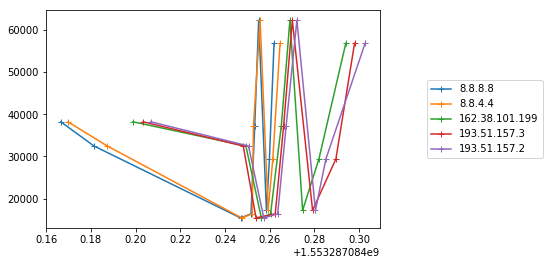

In [9]:
%matplotlib inline
ans.multiplot(lambda x, y: (y[IP].src, (y.time, y[2].id)), plot_xy=True)

LE constructeur  `str()` cpeut être utiliser pour "builder" un paquet et le voir tel qu'il va être sur le réseau.

In [13]:
pkt = IP() / UDP() / DNS(qd=DNSQR())
str(pkt)

"b'E\\x00\\x00=\\x00\\x01\\x00\\x00@\\x11|\\xad\\x7f\\x00\\x00\\x01\\x7f\\x00\\x00\\x01\\x005\\x005\\x00)\\xb6\\xd3\\x00\\x00\\x01\\x00\\x00\\x01\\x00\\x00\\x00\\x00\\x00\\x00\\x03www\\x07example\\x03com\\x00\\x00\\x01\\x00\\x01'"

La représentation hexadécimale n'est pas évidente à lire et la méthode summary permet de l'afficher "en clair"

In [14]:
print(pkt.summary())

IP / UDP / DNS Qry "b'www.example.com'" 


  - "hexdump" les Bytes du paquet de la même façon qu'avec la commande "tcpdump -xX"

In [15]:
hexdump(pkt)

0000  45 00 00 3D 00 01 00 00 40 11 7C AD 7F 00 00 01  E..=....@.|.....
0010  7F 00 00 01 00 35 00 35 00 29 B6 D3 00 00 01 00  .....5.5.)......
0020  00 01 00 00 00 00 00 00 03 77 77 77 07 65 78 61  .........www.exa
0030  6D 70 6C 65 03 63 6F 6D 00 00 01 00 01           mple.com.....


On peut dumper le paquet , couche par couche , en affichant les valeurs de chaque champ comme dans Wireshark

In [3]:
pkt.show()

###[ IP ]### 
  version   = 4
  ihl       = None
  tos       = 0x0
  len       = None
  id        = 1
  flags     = 
  frag      = 0
  ttl       = 64
  proto     = udp
  chksum    = None
  src       = 127.0.0.1
  dst       = 127.0.0.1
  \options   \
###[ UDP ]### 
     sport     = domain
     dport     = domain
     len       = None
     chksum    = None
###[ DNS ]### 
        id        = 0
        qr        = 0
        opcode    = QUERY
        aa        = 0
        tc        = 0
        rd        = 1
        ra        = 0
        z         = 0
        ad        = 0
        cd        = 0
        rcode     = ok
        qdcount   = 1
        ancount   = 0
        nscount   = 0
        arcount   = 0
        \qd        \
         |###[ DNS Question Record ]### 
         |  qname     = 'www.example.com'
         |  qtype     = A
         |  qclass    = IN
        an        = None
        ns        = None
        ar        = None



  - On peut afficher un paquet et faire le lien avec l'hexa: 

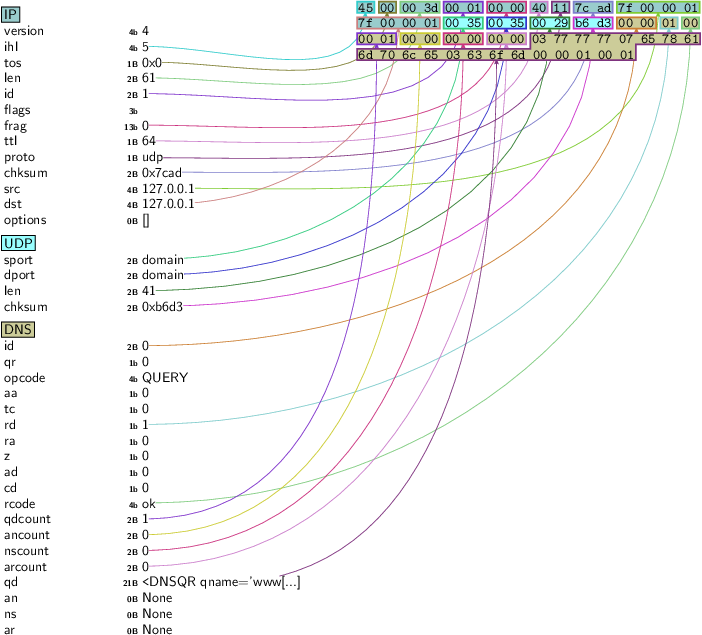

In [3]:
pkt.canvas_dump()

Scapy a une fonction `traceroute()`, qui basiquement fait varier le TTL `sr(IP(ttl=(1..30))` et créé un objet `TracerouteResult` , qui hérite de la classe `SndRcvList()`. On peut tracerouter sur plusieurs ports

In [17]:
ans,unans = traceroute(["cas.umontpellier.fr","www.iutbeziers.fr","www.lpojeanmoulinbeziers.fr"],dport=[80,443],maxttl=17,retry=-2)

Begin emission:
Finished sending 102 packets.
Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 2 packets.
Begin emission:
Finished sending 2 packets.

Received 96 packets, got 96 answers, remaining 0 packets
   193.51.152.65:tcp443 193.51.152.65:tcp80 194.199.227.80:tcp443 194.199.227.80:tcp80 81.88.48.95:tcp443 81.88.48.95:tcp80  
1  192.168.16.1    11   192.168.16.1    11  192.168.16.1    11    192.168.16.1    11   192.168.16.1    11 192.168.16.1    11 
2  192.168.1.1     11   192.168.1.1     11  192.168.1.1     11    192.168.1.1     11   192.168.1.1     11 192.168.1.1     11 
3  80.10.239.41    11   80.10.239.41    11  80.10.239.41    11    80.10.239.41    11   80.10.239.41    11 80.10.239.41    11 
4  193.253.95.66   11   193.253.95.66   11  193.253.95.66   11    193.253.95.66   11   193.253.95.66   11 193.253.95.66   11 
5  193.252.101.158 11   193.252.101.158 11  193.252.101.158 11    193.252.101.158 11   193.252.101.158 11 193.252.101.158 11 
6  193.2

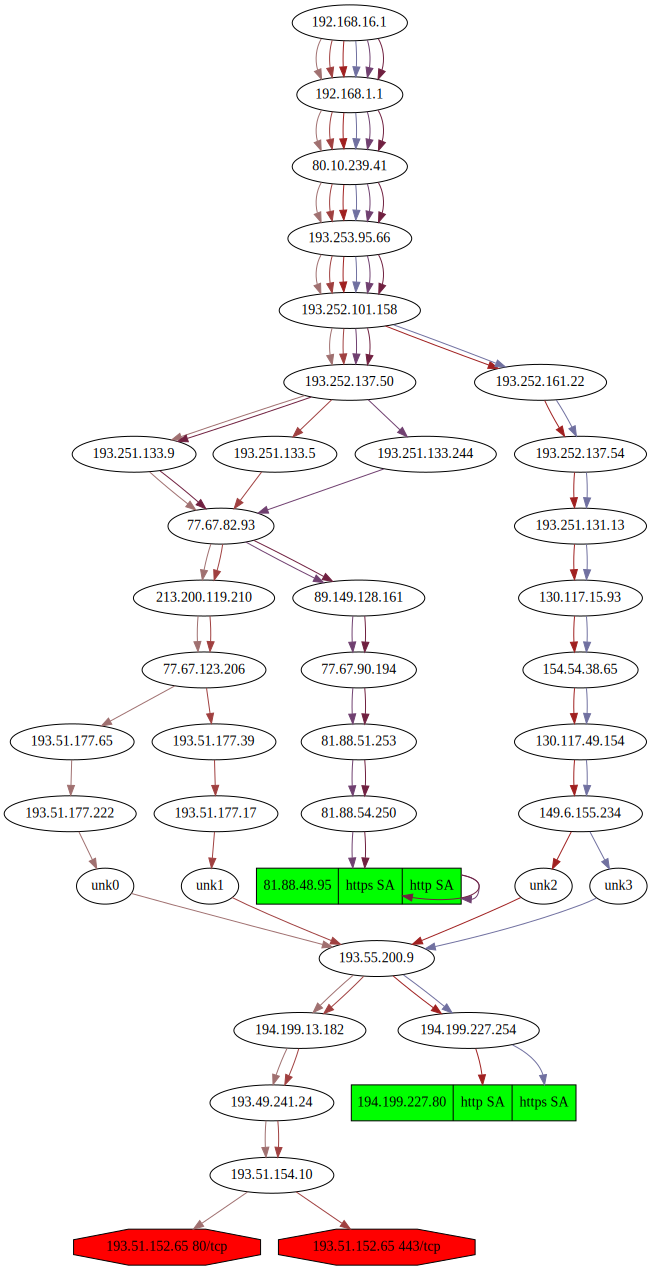

In [18]:
ans.graph(target="> /tmp/graph.svg", ASres=None, type='svg')
from IPython.display import SVG
SVG(filename='/tmp/graph.svg')

Le résultat peut être visualiser sur une carte 

In [8]:
%matplotlib inline
ans,unans=sr(IP(dst="www.google.fr")/TCP(sport=[RandShort()]*100))


Begin emission:
Finished sending 100 packets.

Received 102 packets, got 100 answers, remaining 0 packets


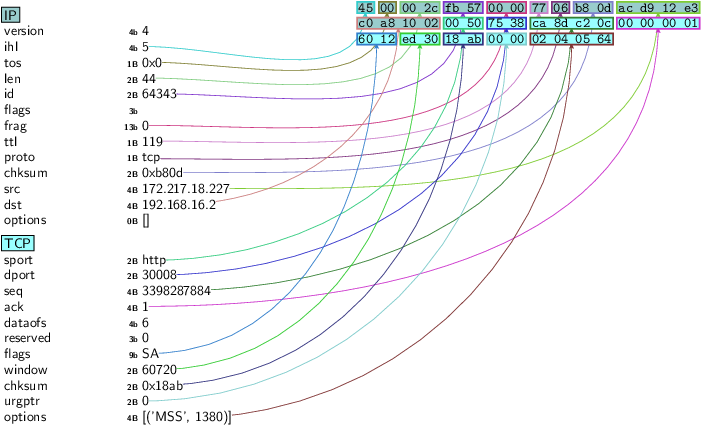

In [9]:
ans[0][1].canvas_dump()

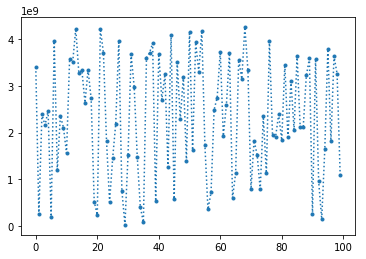

In [10]:
ans.plot(lambda x:x[1].seq,linestyle='dotted',marker='.')

## Answering machines

NFQUEUE est une cible NETFILTER qui peut être utilisée pour transférer des paquets en userland.
Il est accessible par Python et Scapy et peut être utiliser afin de manipuler les paquets reçus (par exemple pour faire du man in the middle).
Lancez la redirection iptables, le script ci-dessous et depuis votre container pinguez le DNS de Google 8.8.8.8 après avoir lancé le script Python "nfqueue_listener.py".

In [ ]:
%%bash
sudo iptables -I OUTPUT --destination 8.8.8.8 -p icmp -o eth0 -j NFQUEUE --queue-num 2807

In [49]:
# source https://raw.githubusercontent.com/milesrichardson/docker-nfqueue-scapy/master/nfqueue_listener.py
from scapy.all import IP
from netfilterqueue import NetfilterQueue
import socket
from pprint import pprint
import json
import os
import sys
import logging

try:
    QUEUE_NUM = int(os.getenv('QUEUE_NUM', 2807))
except ValueError as e:
    sys.stderr.write('Error: env QUEUE_NUM must be integer\n')
    sys.exit(1)

def callback(pkt):

    try:
        packet = IP(pkt.get_payload())
        pprint(packet)
        pkt.accept()
    except Exception as e:
        print('Error: %s' % str(e))
        pkt.drop()

sys.stdout.write('Listening on NFQUEUE queue-num %s... \n' % str(QUEUE_NUM))

nfqueue = NetfilterQueue()
nfqueue.bind(QUEUE_NUM, callback)
s = socket.fromfd(nfqueue.get_fd(), socket.AF_UNIX, socket.SOCK_STREAM)
try:
    nfqueue.run_socket(s)
except KeyboardInterrupt:
    sys.stdout.write('Exiting \n')

s.close()
nfqueue.unbind()

Listening on NFQUEUE queue-num 2807... 
<IP  version=4 ihl=5 tos=0x0 len=84 id=3675 flags=DF frag=0 ttl=64 proto=icmp chksum=0x4b94 src=192.168.16.2 dst=8.8.8.8 |<ICMP  type=echo-request code=0 chksum=0x7894 id=0x1047 seq=0x1 |<Raw  load='\x04\x00\x94\\\x00\x00\x00\x00\x11\xf4\x06\x00\x00\x00\x00\x00\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1c\x1d\x1e\x1f !"#$%&\'()*+,-./01234567' |>>>
<IP  version=4 ihl=5 tos=0x0 len=84 id=3692 flags=DF frag=0 ttl=64 proto=icmp chksum=0x4b83 src=192.168.16.2 dst=8.8.8.8 |<ICMP  type=echo-request code=0 chksum=0xe18e id=0x1047 seq=0x2 |<Raw  load='\x05\x00\x94\\\x00\x00\x00\x00\xa7\xf8\x06\x00\x00\x00\x00\x00\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1c\x1d\x1e\x1f !"#$%&\'()*+,-./01234567' |>>>
<IP  version=4 ihl=5 tos=0x0 len=84 id=3758 flags=DF frag=0 ttl=64 proto=icmp chksum=0x4b41 src=192.168.16.2 dst=8.8.8.8 |<ICMP  type=echo-request code=0 chksum=0x3589 id=0x1047 seq=0x3 |<Raw  load='\x06\x00\x94\\\x00\x00\x00\x00R\xfd\x06\x00\x00

SystemError: <method 'run_socket' of 'netfilterqueue.NetfilterQueue' objects> returned NULL without setting an error

# Exercices

###  EXo1 SCAN de port: Modifiez ce script afin de scanner les ports de 1 à 1024 des machines de la salle

In [17]:
from scapy.all import *
import logging
logging.getLogger("scapy.runtime").setLevel(logging.ERROR)

 
dst_ip = "10.255.255.135"
src_port = RandShort()
dst_port=443
 
tcp_connect_scan_resp = sr1(IP(dst=dst_ip)/TCP(sport=src_port,dport=dst_port,flags="S"),timeout=10)
if(str(type(tcp_connect_scan_resp))=="<type 'NoneType'>"):
    print("Closed")
elif(tcp_connect_scan_resp.haslayer(TCP)):
    if(tcp_connect_scan_resp.getlayer(TCP).flags == 0x12):
        send_rst = sr(IP(dst=dst_ip)/TCP(sport=src_port,dport=dst_port,flags="AR"),timeout=10)
        print("Open")
    elif (tcp_connect_scan_resp.getlayer(TCP).flags == 0x14):
        print("Closed")

Begin emission:
Finished sending 1 packets.

Received 5 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished sending 1 packets.

Received 23 packets, got 0 answers, remaining 1 packets
Open


### Exo2 Requête SNMP: Modifiez ce script afin de recueillir et des d'afficher des informations sur les kernels Linux des serveurs de l'IUT ( Vérifiez que le port 161 udp est ouvert et passez votre requête )

In [15]:
p = IP(dst="10.255.255.135")/UDP(sport=161)/SNMP(community="publicbeziers",PDU=SNMPget(varbindlist=[SNMPvarbind(oid=ASN1_OID("1.3.6.1.2.1.1.1.0"))]))
print(p)


Begin emission:
Finished sending 1 packets.

Received 3 packets, got 1 answers, remaining 0 packets


<IP  version=4 ihl=5 tos=0x0 len=147 id=11044 flags=DF frag=0 ttl=62 proto=udp chksum=0x3605 src=10.255.255.135 dst=192.168.16.2 |<UDP  sport=snmp dport=snmp len=127 chksum=0x23aa |<SNMP  version='v2c' 0x1 <ASN1_INTEGER[1]> community=<ASN1_STRING[b'publicbeziers']> PDU=<SNMPresponse  id=0x0 <ASN1_INTEGER[0]> error='no_error' 0x0 <ASN1_INTEGER[0]> error_index=0x0 <ASN1_INTEGER[0]> varbindlist=[<SNMPvarbind  oid=<ASN1_OID['.1.3.6.1.2.1.1.1.0']> value=<ASN1_STRING[b'Linux registry 4.9.0-8-amd64 #1 SMP Debian 4.9.130-2 (2018-10-27) x86_64']> |>] |> |>>>

In [16]:
a=sr1(p)
print(a)

Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
b'E\x00\x00\x93E\xe5@\x00>\x11\x1bD\n\xff\xff\x87\xc0\xa8\x10\x02\x00\xa1\x00\xa1\x00\x7f#\xaa0u\x02\x01\x01\x04\rpublicbeziers\xa2a\x02\x01\x00\x02\x01\x00\x02\x01\x000V0T\x06\x08+\x06\x01\x02\x01\x01\x01\x00\x04HLinux registry 4.9.0-8-amd64 #1 SMP Debian 4.9.130-2 (2018-10-27) x86_64'


### Exo 3 Modifiez  ce script qui sniffe le réseau avec une fonction de callback qui affiche les sources/dest  IP afin qu'il affiche aussi les ports sources et destination ainsi que le type de paquets



In [19]:
# coding: utf-8
# source https://thepacketgeek.com/scapy-sniffing-with-custom-actions-part-1/
from collections import Counter
from scapy.all import sniff
 
## Create a Packet Counter
packet_counts = Counter()
 
## Define our Custom Action function
def custom_action(packet):
    # Create tuple of Src/Dst in sorted order
    key = tuple(sorted([packet[0][1].src, packet[0][1].dst]))
    packet_counts.update([key])
    return f"Packet #{sum(packet_counts.values())}: {packet[0][1].src} ==> {packet[0][1].dst}"
 
## Setup sniff, filtering for IP traffic
sniff(filter="ip", prn=custom_action, count=10)
 
## Print out packet count per A <--> Z address pair
print("\n".join(f"{f'{key[0]} <--> {key[1]}'}: {count}" for key, count in packet_counts.items()))

Packet #1: 192.168.16.2 ==> 192.168.16.1
Packet #2: 192.168.16.1 ==> 192.168.16.2
Packet #3: 192.168.16.1 ==> 192.168.16.2
Packet #4: 192.168.16.2 ==> 192.168.16.1
Packet #5: 192.168.16.2 ==> 192.168.16.1
Packet #6: 192.168.16.1 ==> 192.168.16.2
Packet #7: 192.168.16.2 ==> 192.168.16.1
Packet #8: 192.168.16.1 ==> 192.168.16.2
Packet #9: 192.168.16.2 ==> 192.168.16.1
Packet #10: 192.168.16.1 ==> 192.168.16.2
192.168.16.1 <--> 192.168.16.2: 10


Vous aurez en sortie cet affichage:
```bash
student@bf4631fcd5a2:~/python/tp-python-reseaux/secu$ sudo python sniffons.py 
Packet #1: proto: TCP 192.168.16.2 ==> 10.255.255.135 sport: 45910 ==>  dport:80 
Packet #2: proto: TCP 192.168.16.2 ==> 10.255.255.135 sport: 40240 ==>  dport:443 
Packet #3: proto: TCP 10.255.255.135 ==> 192.168.16.2 sport: 80 ==>  dport:45910 
Packet #4: proto: UDP 192.168.16.2 ==> 10.255.255.200 sport: 57700 ==>  dport:53 
Packet #5: proto: TCP 10.255.255.135 ==> 192.168.16.2 sport: 443 ==>  dport:40240 
Packet #6: proto: TCP 192.168.16.2 ==> 10.255.255.135 sport: 40240 ==>  dport:443 
Packet #7: proto: UDP 10.255.255.200 ==> 192.168.16.2 sport: 53 ==>  dport:57700 
Packet #8: proto: TCP 192.168.16.2 ==> 10.255.255.135 sport: 45914 ==>  dport:80 
Packet #9: proto: TCP 192.168.16.2 ==> 10.255.255.135 sport: 40244 ==>  dport:443 
Packet #10: proto: TCP 10.255.255.135 ==> 192.168.16.2 sport: 80 ==>  dport:45914 
Packet #11: proto: TCP 10.255.255.135 ==> 192.168.16.2 sport: 443 ==>  dport:40244 
Packet #12: proto: TCP 192.168.16.2 ==> 10.255.255.135 sport: 40244 ==>  dport:443 
Packet #13: proto: TCP 192.168.16.2 ==> 10.255.255.135 sport: 40244 ==>  dport:443 
Packet #14: proto: TCP 192.168.16.2 ==> 10.255.255.135 sport: 45918 ==>  dport:80 
Packet #15: proto: TCP 10.255.255.135 ==> 192.168.16.2 sport: 80 ==>  dport:45918 
Packet #16: proto: TCP 192.168.16.2 ==> 192.168.16.1 sport: 8888 ==>  dport:52556 
Packet #17: proto: TCP 192.168.16.1 ==> 192.168.16.2 sport: 52556 ==>  dport:8888 
Packet #18: proto: TCP 192.168.16.2 ==> 192.168.16.1 sport: 8888 ==>  dport:52556 
Packet #19: proto: TCP 192.168.16.1 ==> 192.168.16.2 sport: 52546 ==>  dport:8888 
Packet #20: proto: TCP 192.168.16.2 ==> 192.168.16.1 sport: 8888 ==>  dport:52546 
Packet #21: proto: TCP 192.168.16.1 ==> 192.168.16.2 sport: 52544 ==>  dport:8888 
Packet #22: proto: TCP 192.168.16.1 ==> 192.168.16.2 sport: 52552 ==>  dport:8888 
Packet #23: proto: TCP 192.168.16.2 ==> 192.168.16.1 sport: 8888 ==>  dport:52544 
Packet #24: proto: TCP 192.168.16.2 ==> 192.168.16.1 sport: 8888 ==>  dport:52552 
Packet #25: proto: TCP 192.168.16.1 ==> 192.168.16.2 sport: 52548 ==>  dport:8888 
Packet #26: proto: TCP 192.168.16.2 ==> 192.168.16.1 sport: 8888 ==>  dport:52548 
Packet #27: proto: TCP 192.168.16.1 ==> 192.168.16.2 sport: 52550 ==>  dport:8888 
Packet #28: proto: TCP 192.168.16.2 ==> 192.168.16.1 sport: 8888 ==>  dport:52550 
Packet #29: proto: TCP 192.168.16.1 ==> 192.168.16.2 sport: 52554 ==>  dport:8888 
Packet #30: proto: TCP 192.168.16.2 ==> 192.168.16.1 sport: 8888 ==>  dport:52554 
Packet #31: 192.168.16.2 ==> 8.8.8.8
```

### Exo 4 Réalisez un scan de port sur le port 80 et 443 sur les réseaux 10.255.255.0/16